| Name | Surname | ID Number |
|------|---------|---------------------|
| Andrea | Turci | 2106724 |

In [1]:
library("dplyr", warn.conflicts = FALSE, quietly = TRUE)
library("ggplot2", warn.conflicts = FALSE, quietly = TRUE)
library("spatstat", warn.conflicts = FALSE, quietly = TRUE)
library("coda", warn.conflicts = FALSE, quietly = TRUE)
# library("rjags", warn.conflicts = FALSE, quietly = TRUE)
library("gridExtra", warn.conflicts = FALSE, quietly = TRUE)
library(geosphere)
library(Hmisc)
library(rstan)

spatstat.geom 3.2-9

spatstat.random 3.2-3


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


spatstat.explore 3.2-7

spatstat.model 3.2-11

spatstat.linnet 3.1-5


spatstat 3.0-8 
For an introduction to spatstat, type ‘beginner’ 



Attaching package: ‘geosphere’


The following object is masked from ‘package:spatstat.geom’:

    perimeter



Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units


Loading required package: StanHeaders

code for methods in class “Rcpp_model_base” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_model_base” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit” was not checked for suspicious field assignments (rec

Ex1

y death soldiers 0 1 2 3 4 ≥ 5
n1 observations 109 65 22 3 1 0
n2 observations 144 91 32 11 2 0

A study on water quality of streams, a high level of bacter X was defined as a level greater than 100
per 100 ml of stream water. n = 116 samples were taken from streams having a high environmental
impact on pandas. Out of these, y = 11 had a high bacter X level.
• indicating with p the probability that a sample of water taken from the stream has a high bacter
X level,
(a) find the frequentist estimator for p
(b) using a Beta(1, 10) prior for p, calculate and posterior distribution P(p

 y)

In [2]:
y <- c(0, 1, 2, 3, 4, ">=5")
n1 <- c(109, 65, 22, 3, 1, 0)
n2 <- c(144, 91, 32, 11, 2, 0)

combined_obs <- n1 + n2

total_counts <- sum(combined_obs)
total_deaths <- sum(c(0, 1, 2, 3, 4, 5) * combined_obs)

In [3]:
lambda <- seq(0.001, 1, 0.001)
post_values <- dgamma(lambda, shape = total_deaths + 1, rate = total_counts)
post_values <- post_values / sum(post_values)

options(repr.plot.width = 8, repr.plot.height = 8)

The mean is 0.6645833 
The standard deviation is 0.001395138 
The median is 0.6635 
95% credibility interval is ( 0.594375 ; 0.739625 ) 


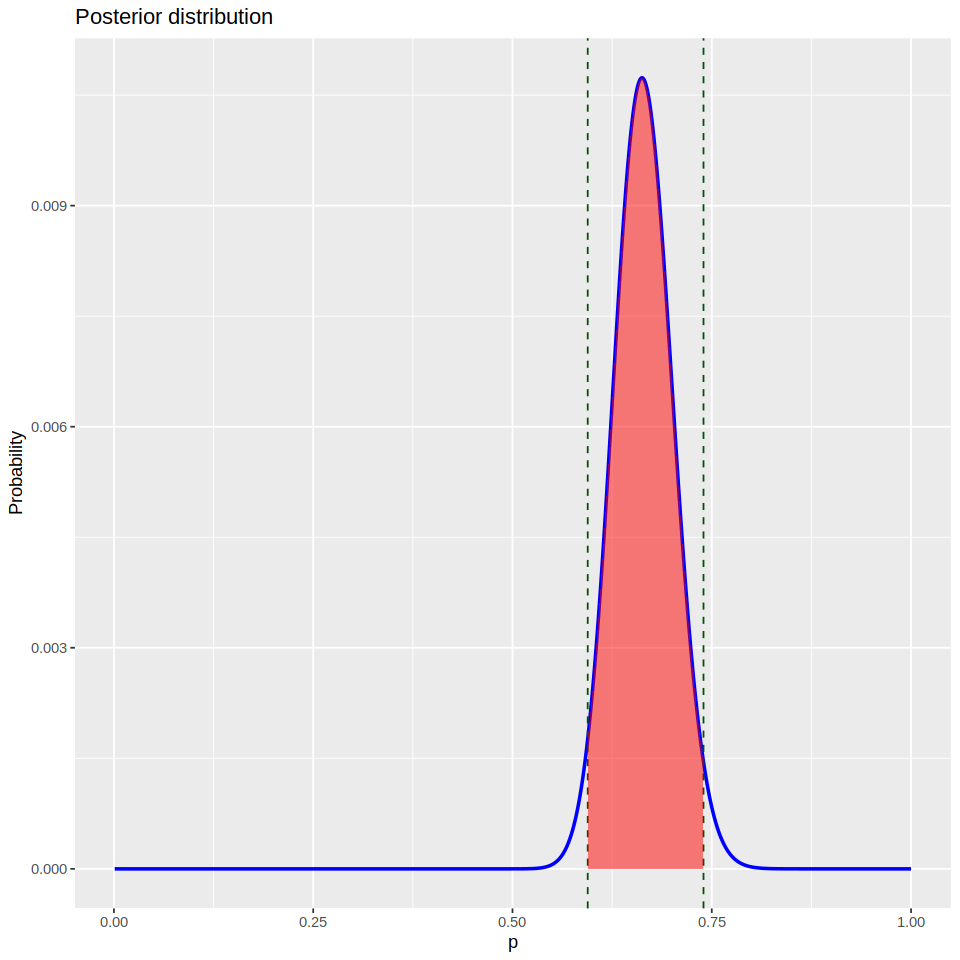

In [4]:
mean <- wtd.mean(lambda, post_values, normwt = TRUE)
var <- wtd.var(lambda, post_values, normwt = TRUE)
median <- weighted.median(lambda, post_values)
quantiles <- wtd.quantile(lambda, post_values, c(0.025, 0.975), normwt = TRUE)

cat("The mean is", mean, '\n')
cat("The standard deviation is", var,'\n')
cat("The median is", median,'\n')
cat("95% credibility interval is (", quantiles[1], ";", quantiles[2], ")", "\n")

ggplot(data = data.frame(lambda, post_values), aes(x = lambda, y = post_values)) +
  # geom_point(color = "red", size = 1.5) +
  geom_line(color = "blue", linewidth = 1) +
  # geom_vline(xintercept = mean_bayes,
  #            linetype = "dashed", color = "blue") +
  geom_vline(xintercept = quantiles[1],
             linetype = "dashed", color = "#035003") +
  geom_vline(xintercept = quantiles[2],
             linetype = "dashed", color = "#035003") +

  geom_ribbon(data = subset(data.frame(lambda, post_values),
                            lambda >= (quantiles[1]) & lambda <= (quantiles[2])),
              aes(ymin = 0, ymax = post_values),
              fill = "red", alpha = 0.5) +
  labs(title = "Posterior distribution ",
       x = "p",
       y = "Probability")

In [5]:
likelihood <- dgamma(lambda, shape = total_deaths + 1, rate = total_counts)
prior_f <- function(lambda) {
    return(1/sqrt(lambda))
}
post_values_1 <- prior_f(lambda) * likelihood
post_values_1 <- post_values_1 / sum(post_values_1)

options(repr.plot.width = 8, repr.plot.height = 8)

The mean is 0.6635417 
The standard deviation is 0.00139296 
The median is 0.6625 
95% credibility interval is ( 0.593375 ; 0.738625 ) 


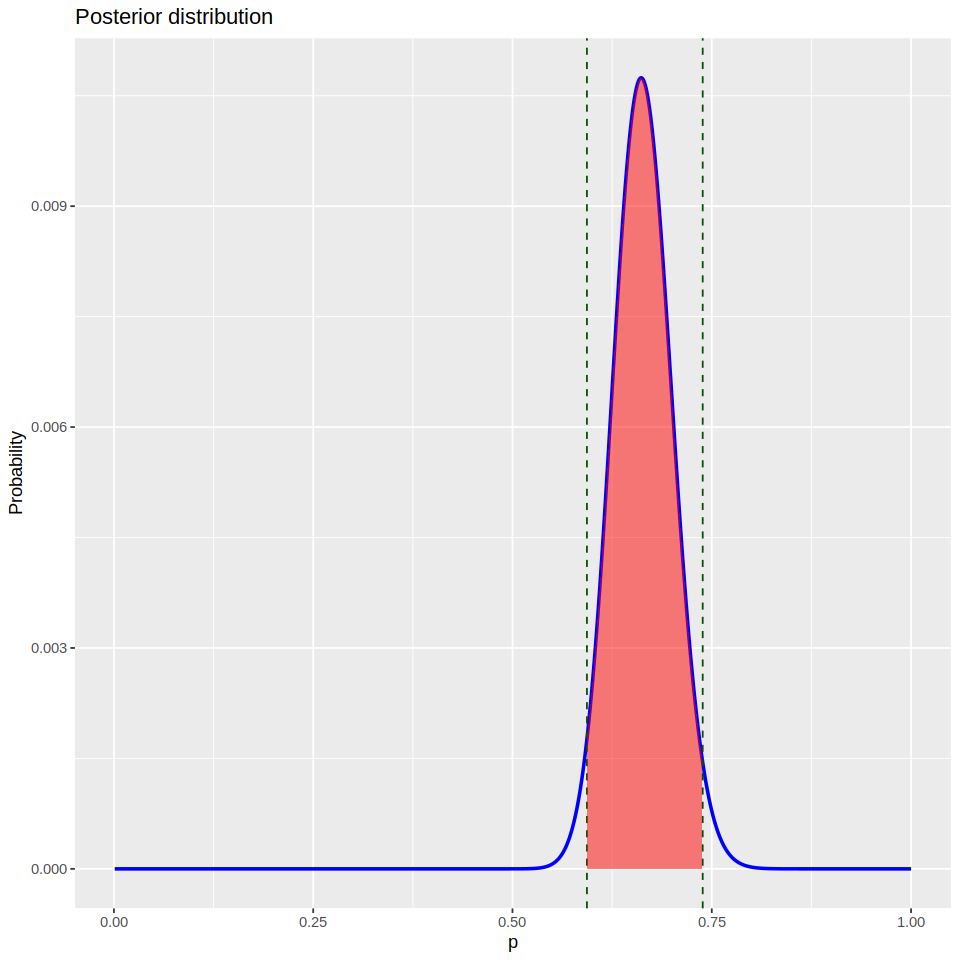

In [6]:
mean <- wtd.mean(lambda, post_values_1, normwt = TRUE)
var <- wtd.var(lambda, post_values_1, normwt = TRUE)
median <- weighted.median(lambda, post_values_1)
quantiles_1 <- wtd.quantile(lambda, post_values_1, c(0.025, 0.975), normwt = TRUE)

cat("The mean is", mean, '\n')
cat("The standard deviation is", var,'\n')
cat("The median is", median,'\n')
cat("95% credibility interval is (", quantiles_1[1], ";", quantiles_1[2], ")", "\n")

ggplot(data = data.frame(lambda, post_values_1), aes(x = lambda, y = post_values_1)) +
  # geom_point(color = "red", size = 1.5) +
  geom_line(color = "blue", linewidth = 1) +
  # geom_vline(xintercept = mean_bayes,
  #            linetype = "dashed", color = "blue") +
  geom_vline(xintercept = quantiles_1[1],
             linetype = "dashed", color = "#035003") +
  geom_vline(xintercept = quantiles_1[2],
             linetype = "dashed", color = "#035003") +

  geom_ribbon(data = subset(data.frame(lambda, post_values_1),
                            lambda >= (quantiles_1[1]) & lambda <= (quantiles_1[2])),
              aes(ymin = 0, ymax = post_values_1),
              fill = "red", alpha = 0.5) +
  labs(title = "Posterior distribution ",
       x = "p",
       y = "Probability")

Ex 2

In [44]:
occurrencies <- rep(0:5, combined_obs)
data_list <- list(y = occurrencies, N = length(occurrencies))

In [45]:
model_string_uniform <- "data {
  int N;
  array[N] int y;
}
parameters {
  real lambda;
}
model {
  lambda ~ beta(1, 1);
  y ~ poisson(lambda);
}"

writeLines(model_string_uniform, "model_string_uniform.stan")

In [46]:
mod <- stan_model("model_string_uniform.stan")

In [49]:
fit <- sampling(
  object = mod,
  data = data_list,
  seed = 123,
  chains = 4,
  iter = 1000,
  warmup = 200,
  thin = 1
)


code for methods in class “Rcpp_stan_fit4model3806f4569c2_” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model3806f4569c2_” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)




SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000532 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 5.32 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:   1 / 1000 [  0%]  (Warmup)
Chain 1: Iteration: 100 / 1000 [ 10%]  (Warmup)
Chain 1: Iteration: 200 / 1000 [ 20%]  (Warmup)
Chain 1: Iteration: 201 / 1000 [ 20%]  (Sampling)
Chain 1: Iteration: 300 / 1000 [ 30%]  (Sampling)
Chain 1: Iteration: 400 / 1000 [ 40%]  (Sampling)
Chain 1: Iteration: 500 / 1000 [ 50%]  (Sampling)
Chain 1: Iteration: 600 / 1000 [ 60%]  (Sampling)
Chain 1: Iteration: 700 / 1000 [ 70%]  (Sampling)
Chain 1: Iteration: 800 / 1000 [ 80%]  (Sampling)
Chain 1: Iteration: 900 / 1000 [ 90%]  (Sampling)
Chain 1: Iteration: 1000 / 1000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.014 seconds (Warm-up)
Chain 1:                0.02 seconds (Sampling)
Chain 1:                0.034 sec

In [50]:
print(fit,pars = c("lambda"), probs = c(0.025, 0.975), digits = 4)

Inference for Stan model: anon_model.
4 chains, each with iter=1000; warmup=200; thin=1; 
post-warmup draws per chain=800, total post-warmup draws=3200.

         mean se_mean     sd   2.5%  97.5% n_eff   Rhat
lambda 0.6647  0.0011 0.0367 0.5944 0.7359  1103 1.0014

Samples were drawn using NUTS(diag_e) at Thu May 30 18:20:33 2024.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [52]:
plot(fit,pars=c("lambda"))

ci_level: 0.8 (80% intervals)

outer_level: 0.95 (95% intervals)



ERROR: [1m[33mError[39m in `check_subclass()`:[22m
[33m![39m `x` must be either a string or a [34m<Geom>[39m object, not an environment.


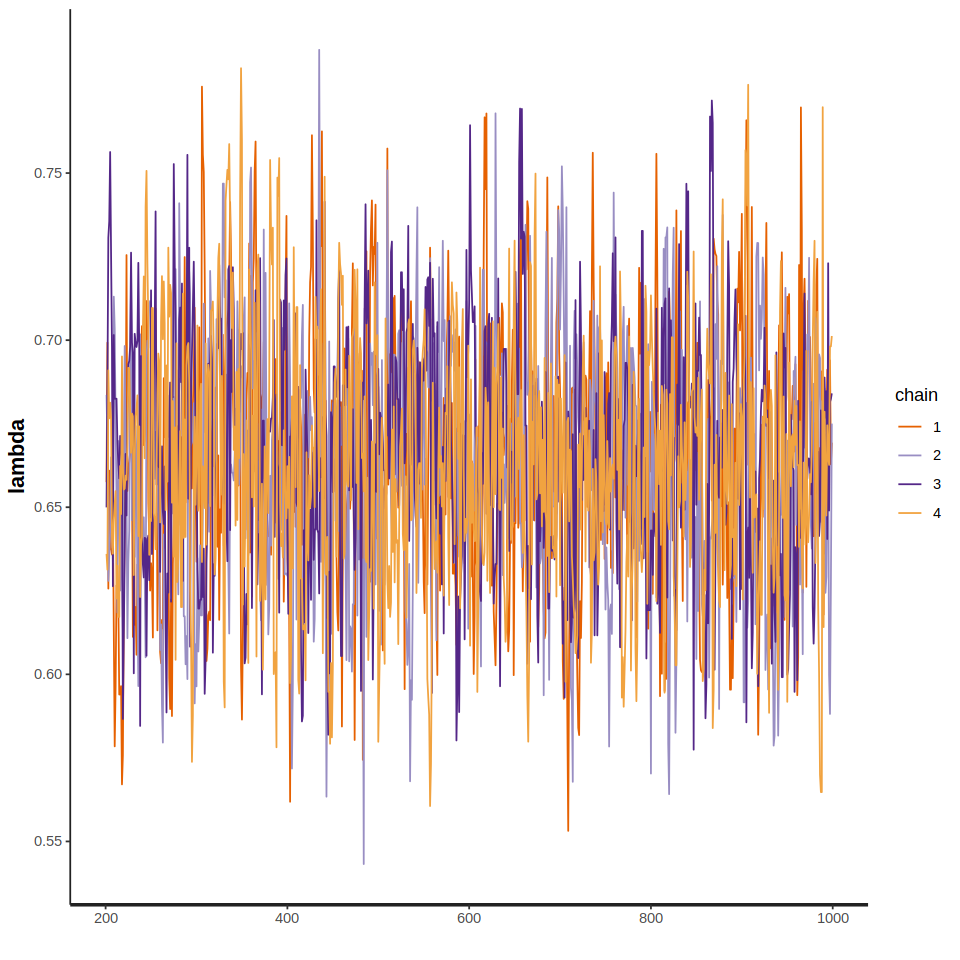

In [53]:
rstan::traceplot(fit,pars=c("lambda"))

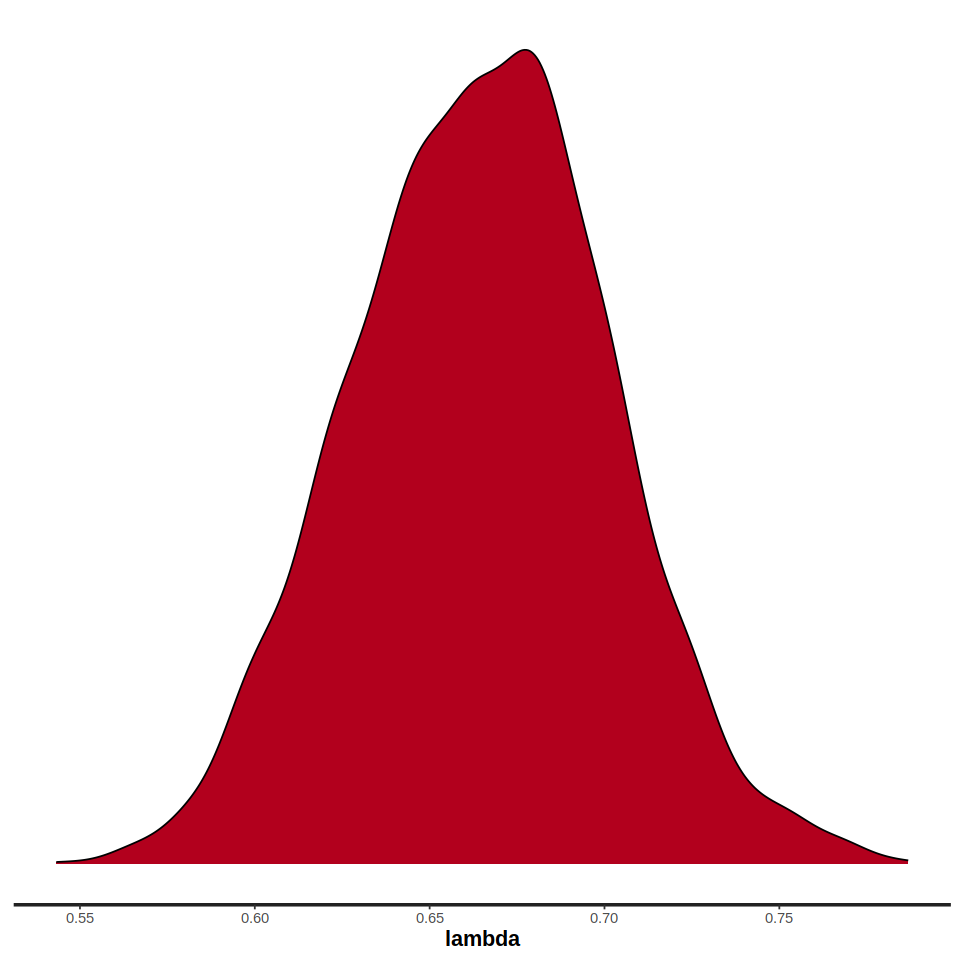

In [54]:
stan_dens(fit)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


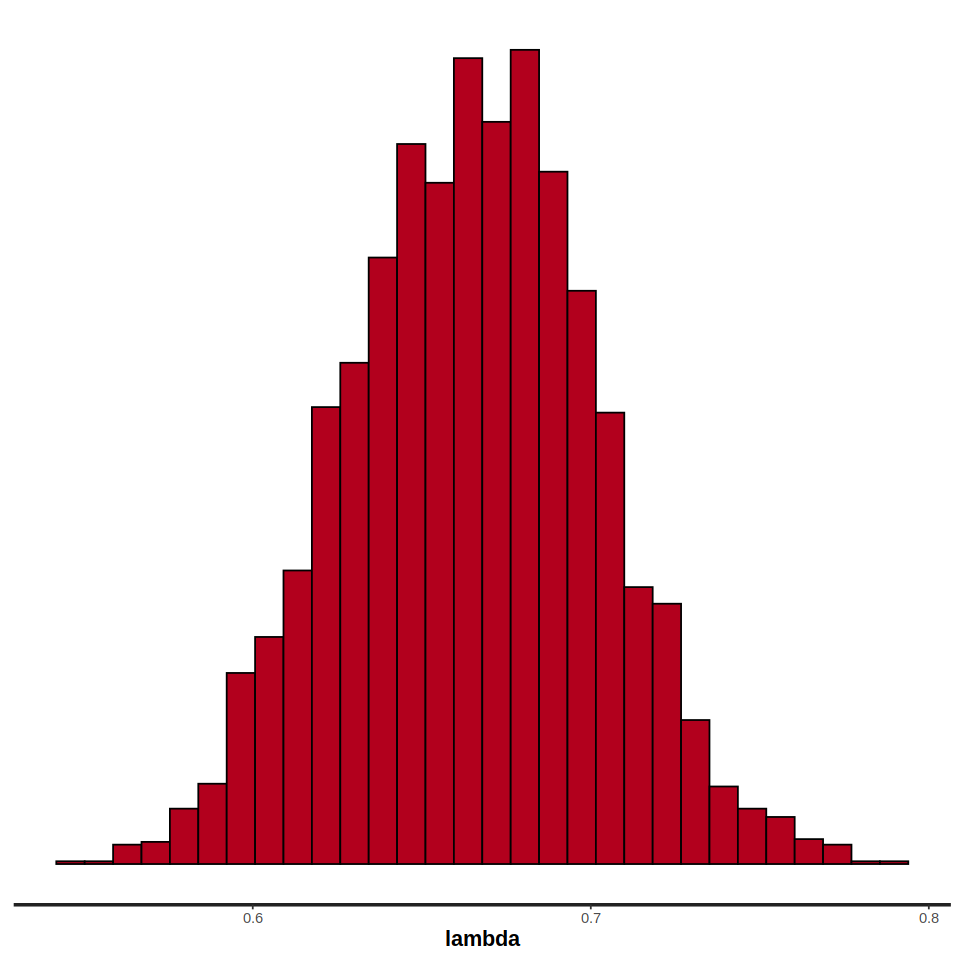

In [55]:
stan_hist(fit)

Ex 3

In [8]:
y <- 11
n <- 116

p <- y/n

mean_freq <- p
var_freq <- (p*(1-p))/n

cat("The frequentist mean is", mean_freq, '\n')
cat("The frequentist variance is", var_freq)

The frequentist mean is 0.09482759 
The frequentist variance is 0.0007399596

The bayesian mean is 0.09448819 
The bayesian variance is 0.0007150888

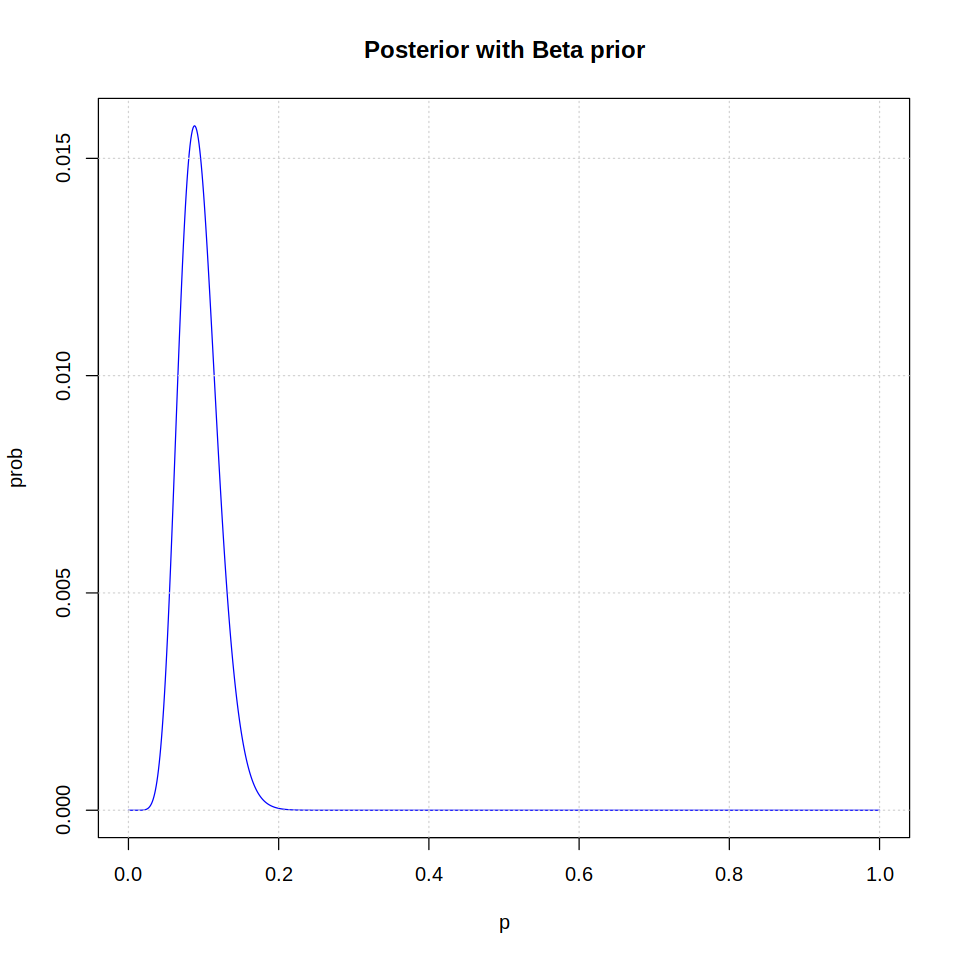

In [9]:
a <- 1
b <- 10

a_prime <- a + y
b_prime <- b + n - y

p <- seq(0, 1, 0.001)
beta_post <- dbeta(p, a_prime, b_prime)

beta_post <- beta_post / sum(beta_post)

p_freq <- y/n

mean_bayes <- a_prime/(a_prime + b_prime)
variance_bayes <- (1/(n+2))**2 * n * p_freq * (1-p_freq)

cat("The bayesian mean is", mean_bayes, '\n')
cat("The bayesian variance is", variance_bayes)

plot(p, beta_post, type = "l", col = "blue", xlab = "p", ylab = "prob", main = "Posterior with Beta prior")
grid()

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


95% credibility interval is ( 0.05 ; 0.151 ) 


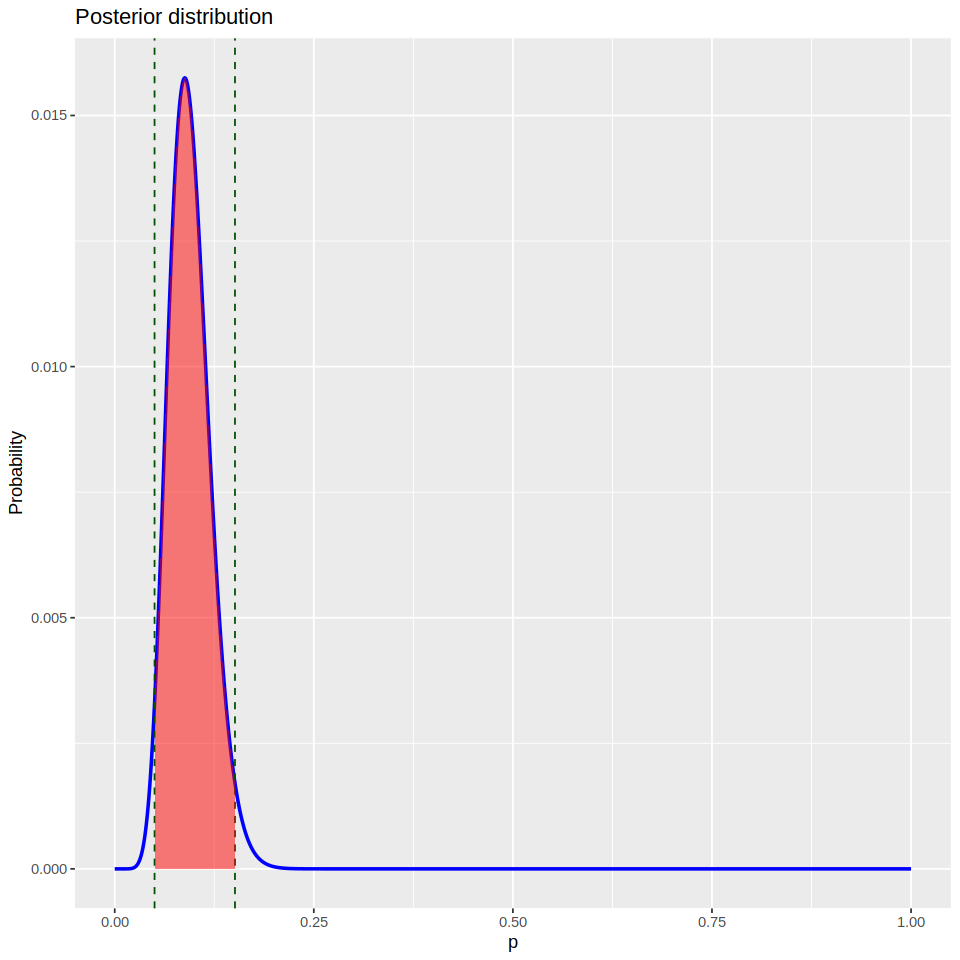

In [10]:
quantiles <- wtd.quantile(p, beta_post, c(0.025, 0.975), normwt = TRUE)

cat("95% credibility interval is (", quantiles[1], ";", quantiles[2], ")", "\n")

ggplot(data = data.frame(p, beta_post), aes(x = p, y = beta_post)) +
  # geom_point(color = "red", size = 1.5) +
  geom_line(color = "blue", linewidth = 1) +
  # geom_vline(xintercept = mean_bayes,
  #            linetype = "dashed", color = "blue") +
  geom_vline(xintercept = quantiles[1],
             linetype = "dashed", color = "#035003") +
  geom_vline(xintercept = quantiles[2],
             linetype = "dashed", color = "#035003") +

  geom_ribbon(data = subset(data.frame(p, beta_post),
                            p >= (quantiles[1]) & p <= (quantiles[2])),
              aes(ymin = 0, ymax = beta_post),
              fill = "red", alpha = 0.5) +
  labs(title = "Posterior distribution ",
       x = "p",
       y = "Probability")

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


The p-value is 85.26837 %, which is more than the 5% threshold. 
Thus, we cannot reject the null hypothesis based on the frequentist analysis.


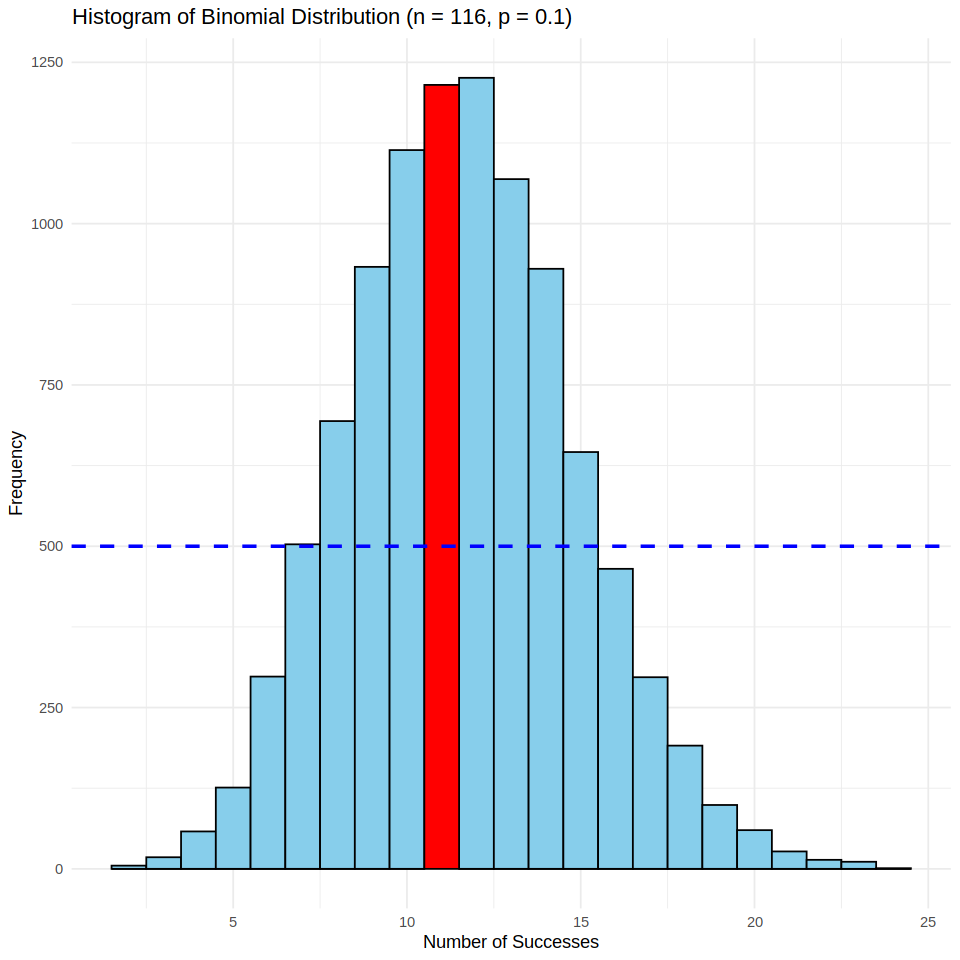

In [11]:
p0 <- 0.1
n <- 116
sample_size <- 10000 # Define the sample size

# Generate a sample from the binomial distribution
binom_sample <- rbinom(sample_size, n, p0)

# Create a data frame for plotting
binom_data <- data.frame(counts = binom_sample)

# Plot the histogram using ggplot2
# ggplot(binom_data, aes(x = counts)) +
#   geom_histogram(binwidth = 1, color = "black", fill = "skyblue") +
#   labs(title = "Histogram of Binomial Distribution (n = 116, p = 0.1)",
#        x = "Number of Successes",
#        y = "Frequency") +
#   theme_minimal()

horizontal_line_value <- 0.05* sample_size

ggplot(binom_data, aes(x = counts)) +
  geom_histogram(binwidth = 1, aes(fill = (counts == 11)), color = "black") +
  scale_fill_manual(values = c("FALSE" = "skyblue", "TRUE" = "red")) +
  labs(title = "Histogram of Binomial Distribution (n = 116, p = 0.1)",
       x = "Number of Successes",
       y = "Frequency") +
  theme_minimal() +
  theme(legend.position = "none") +# Remove legend
  geom_hline(yintercept = 0.05* sample_size, linetype = "dashed", color = "blue", size = 1) # Add horizontal line

  # It lies in the acceptance region

z <- (p_freq - p0) / sqrt(p0 * (1 - p0) / n)
p_value <- 2 * (1 - pnorm(abs(z)))

if (p_value < 0.05) {
  cat("The p-value is", p_value * 100, "%, which is less than the 5% threshold.", # nolinter
      "\nThus, we can reject the null hypothesis based on the frequentist analysis.\n") # nolinter
} else {
  cat("The p-value is", p_value * 100, "%, which is more than the 5% threshold.", # nolinter
      "\nThus, we cannot reject the null hypothesis based on the frequentist analysis.\n") # nolinter
}

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


95% credibility interval is ( 0.05 ; 0.151 ) 


Warning message:
“Removed 750 rows containing missing values or values outside the scale range
(`geom_line()`).”


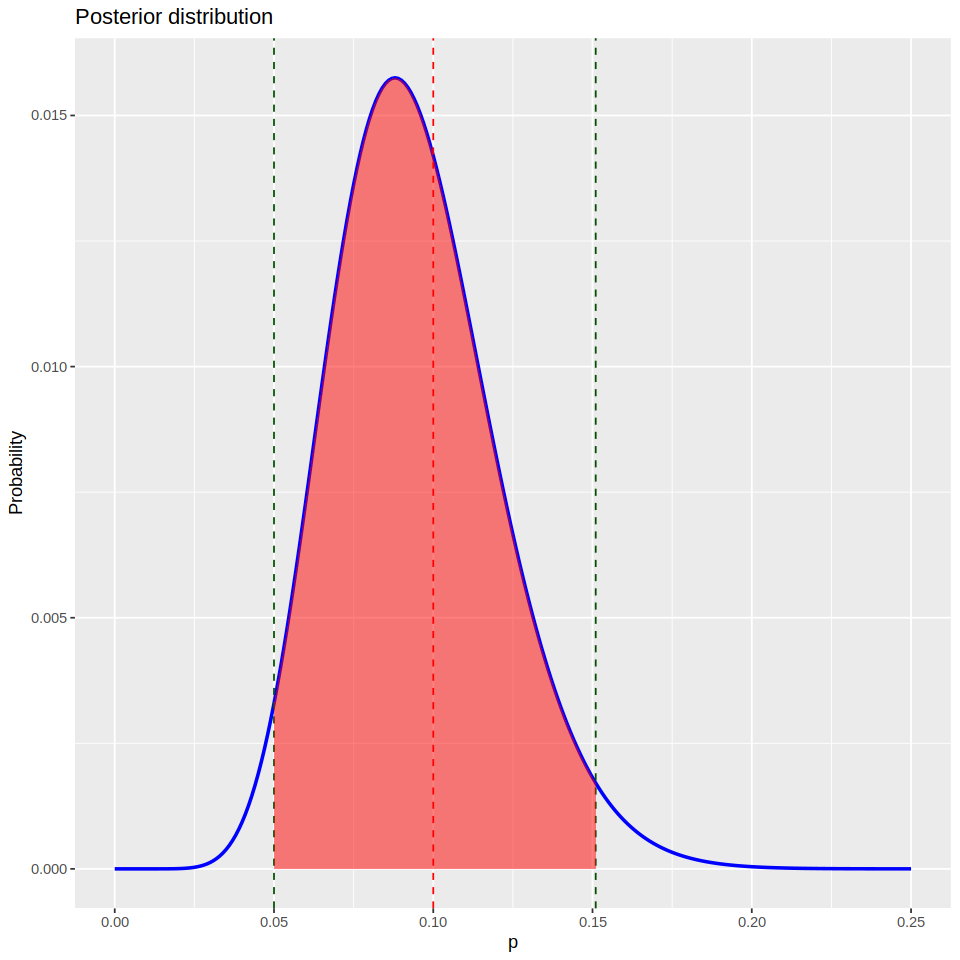

In [12]:
# bayesian approach
# we compute a (1 − α) × 100% credible interval for p
# if p0 lies inside the interval, we do not reject the null hypothesis, H0; if it is outside,
# we reject H0

quantiles <- wtd.quantile(p, beta_post, c(0.025, 0.975), normwt = TRUE)

cat("95% credibility interval is (", quantiles[1], ";", quantiles[2], ")", "\n")

ggplot(data = data.frame(p, beta_post), aes(x = p, y = beta_post)) +
  # geom_point(color = "red", size = 1.5) +
  geom_line(color = "blue", linewidth = 1) +
  # geom_vline(xintercept = mean_bayes,
  #            linetype = "dashed", color = "blue") +
  geom_vline(xintercept = quantiles[1],
             linetype = "dashed", color = "#035003") +
  geom_vline(xintercept = quantiles[2],
             linetype = "dashed", color = "#035003") +

  geom_ribbon(data = subset(data.frame(p, beta_post),
                            p >= (quantiles[1]) & p <= (quantiles[2])),
              aes(ymin = 0, ymax = beta_post),
              fill = "red", alpha = 0.5) +
  labs(title = "Posterior distribution ",
       x = "p",
       y = "Probability")+
  xlim(c(0,0.25)) +
  geom_vline(xintercept = p0,
           linetype = "dashed", color = "red")


a new measurement, performed one month later on n = 165 water samples, gives y = 9 high bacter X level

(e) find the frequentist estimator for p

In [13]:
n1 <- 165
y1 <- 9

p_freq <- y1/n1 

p_freq

[1] 0.05454545

(f) find a bayesian estimator for p, assuming both a Beta(1, 10) prior for p, and assuming the posterior
probability of the older measurement as the prior for the new one.

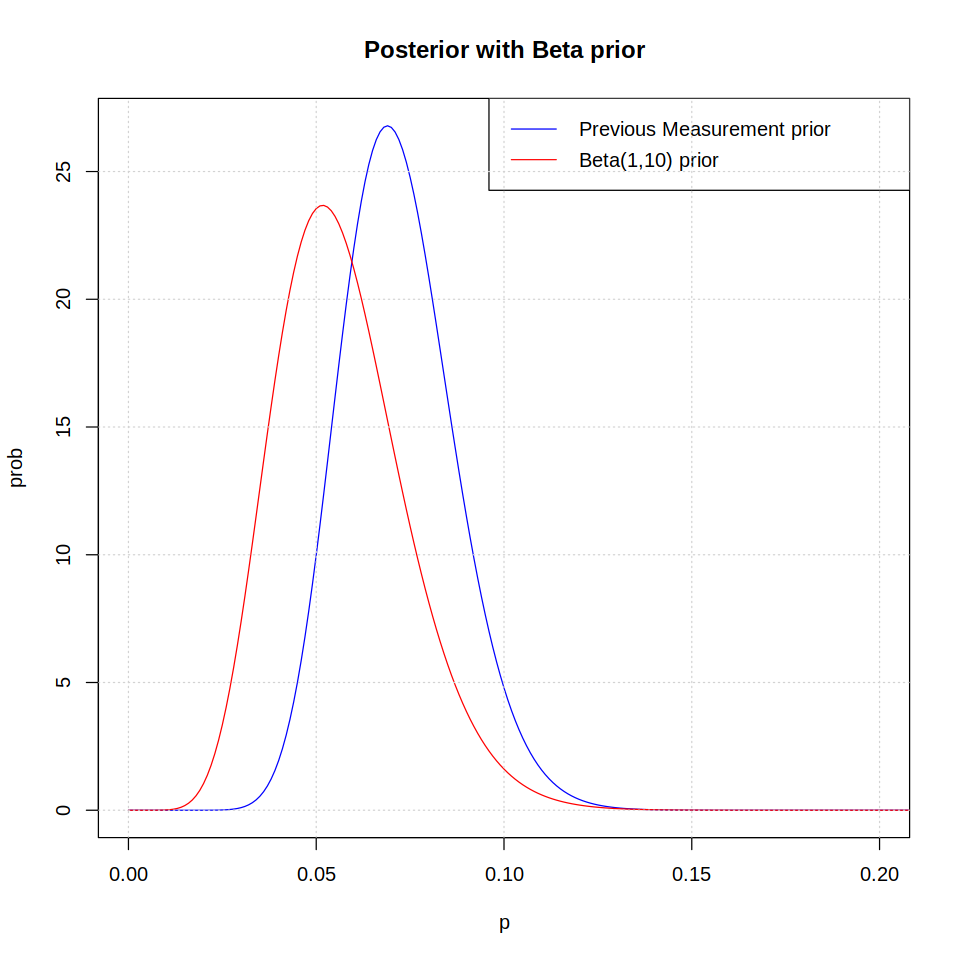

In [14]:
p <- seq(0, 1, 0.001)

# assuming beta(1,10)

beta_prior <- dbeta(p, a, b)
beta_post_1 <- dbeta(p, a + y1, b + n1 - y1)

# assuming older measurement prior

beta_prior <- dbeta(p, a_prime, b_prime)
beta_post_2 <- dbeta(p, a_prime + y1, b_prime + n1 - y1)

plot(p, beta_post_2, type = "l", col = "blue", xlab = "p", xlim = c(0, 0.2), ylab = "prob", main = "Posterior with Beta prior")
lines(p, beta_post_1, type = "l", col = "red", xlab = "p", ylab = "prob", main = "Posterior with Beta prior")
legend("topright", legend = c("Previous Measurement prior", "Beta(1,10) prior"),col = c("blue", "red"), lty=1)
grid()

(g) find the bayesian estimator for p, the posterior mean and variance, and a 95% credible interval


In [15]:
# for beta_post_1
a_prime_1 <- a + y1
b_prime_1 <- b + n1 - y1
mean_bayes_1 <- a_prime_1/(a_prime_1 + b_prime_1)
variance_bayes_1 <- (1/(n1+2))**2 * n1 * p_freq * (1-p_freq)
quantiles_1 <- wtd.quantile(p, beta_post_1, c(0.025, 0.975), normwt = TRUE)

cat("With Beta(1,10) prior, the bayesian mean is", mean_bayes_1, '\n')
cat("With Beta(1,10) prior, the bayesian variance is", variance_bayes_1, '\n')
cat("With Beta(1,10) 95% credibility interval is (", quantiles_1[1], ";", quantiles_1[2], ")", "\n")

# for beta_post_2
a_prime_2 <- a_prime + y1
b_prime_2 <- b_prime + n1 - y1
mean_bayes_2 <- a_prime_2/(a_prime_2 + b_prime_2)
variance_bayes_2 <- (1/(n1+2))**2 * n1 * p_freq * (1-p_freq)
quantiles_2 <- wtd.quantile(p, beta_post_2, c(0.025, 0.975), normwt = TRUE)


cat("With previous measurement prior, the bayesian mean is", mean_bayes_2, '\n')
cat("With previous measurement prior, the bayesian variance is", variance_bayes_2, '\n')
cat("With previous measurementprior 95% credibility interval is (", quantiles_2[1], ";", quantiles_2[2], ")", "\n")

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


With Beta(1,10) prior, the bayesian mean is 0.05681818 
With Beta(1,10) prior, the bayesian variance is 0.0003051056 
With Beta(1,10) 95% credibility interval is ( 0.028 ; 0.09525 ) 


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


With previous measurement prior, the bayesian mean is 0.07191781 
With previous measurement prior, the bayesian variance is 0.0003051056 
With previous measurementprior 95% credibility interval is ( 0.045 ; 0.104 ) 


Warning message:
“Removed 850 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 850 rows containing missing values or values outside the scale range
(`geom_line()`).”


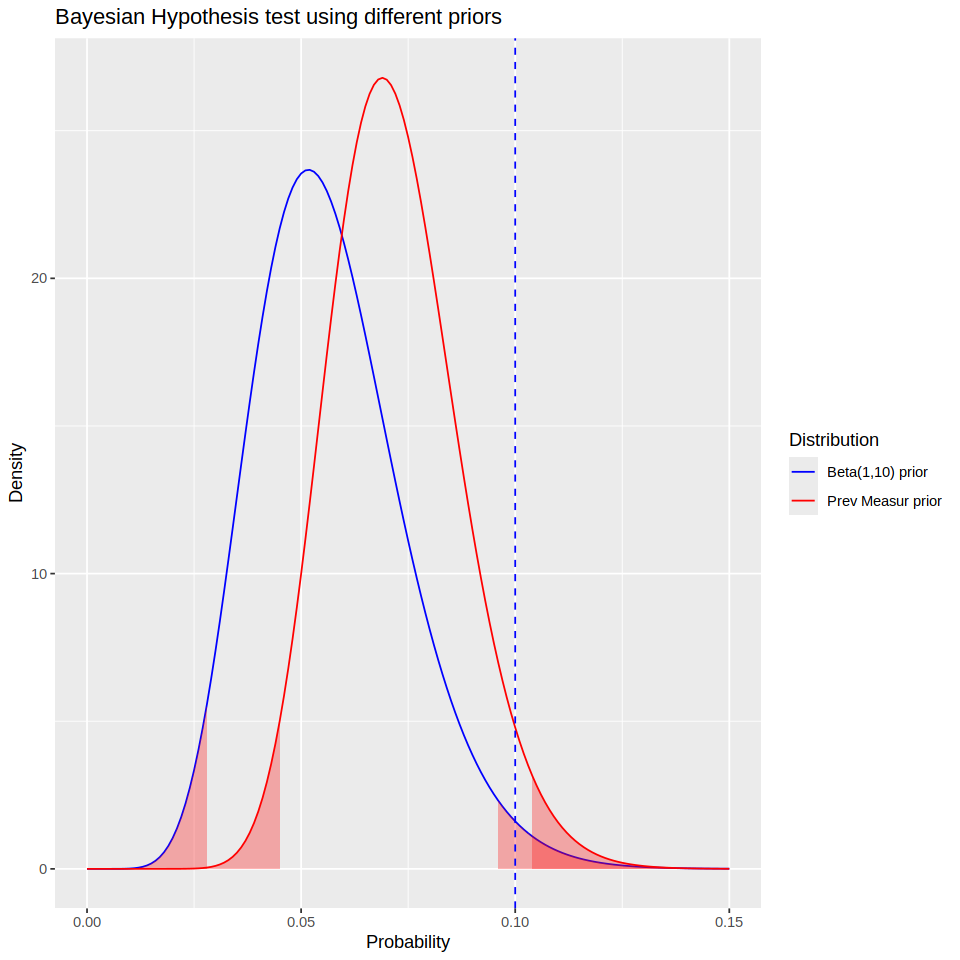

In [16]:
density1 <- beta_post_1
density2 <- beta_post_2

# Create a data frame for plotting
df <- data.frame(p, density1, density2)

# Plot the densities with ggplot2
ggplot(df, aes(x = p)) +
  # Add density line for distribution 1
  xlim(0, 0.15) +
  geom_line(aes(y = density1, color = "Beta(1,10) prior")) +
  # Add density line for distribution 2
  geom_line(aes(y = density2, color = "Prev Measur prior")) +
  # Shade the area under the curve from p = 0.15 onwards for distribution 1
  geom_ribbon(data = subset(df, p >= quantiles_1[2]), aes(ymin = 0, ymax = density1), fill = "red", alpha = 0.3) +
  # Shade the area under the curve from p = 0.15 onwards for distribution 2
  geom_ribbon(data = subset(df, p <= quantiles_1[1]), aes(ymin = 0, ymax = density1), fill = "red", alpha = 0.3) +
geom_ribbon(data = subset(df, p >= quantiles_2[2]), aes(ymin = 0, ymax = density2), fill = "red", alpha = 0.3) +
  # Shade the area under the curve from p = 0.15 onwards for distribution 2
  geom_ribbon(data = subset(df, p <= quantiles_2[1]), aes(ymin = 0, ymax = density2), fill = "red", alpha = 0.3) +

  scale_color_manual(values = c("blue", "red")) + # set color for mean lines
  scale_fill_manual(values = c("blue", "red")) +
#   geom_vline(aes(xintercept = quantiles_1[2]), linetype = "dashed") + # mean lines
#   geom_vline(aes(xintercept = quantiles_1[1]), linetype = "dashed") + # mean lines
geom_vline(aes(xintercept = 0.1), linetype = "dashed", color = "blue") +

  # Set plot labels and title
  labs(x = "Probability", y = "Density", color = "Distribution") +
#   annotate("text", x = c(sum_from_index_freq + 0.13, sum_from_index_bay + 0.13), y = c(0.0008, 0.0002), 
#          label = c(sprintf("p_value = %.4f %% \n", sum_from_index_freq*100),
#                    sprintf("p_value = %.4f %% \n", sum_from_index_bay*100)),
#          color = c("blue", "red"), size = 4, hjust = 0, vjust = -1) + # add mean and var annotations
  ggtitle("Bayesian Hypothesis test using different priors")


In [17]:
# Frequentist hypothesis test

p0 <- 0.1

z <- (p_freq - p0) / sqrt(p0 * (1 - p0) / n1)
p_value <- 2 * (1 - pnorm(abs(z)))

if (p_value < 0.05) {
  cat("The p-value is", p_value * 100, "%, which is less than the 5% threshold.", # nolinter
      "\nThus, we can reject the null hypothesis based on the frequentist analysis.\n") # nolinter
} else {
  cat("The p-value is", p_value * 100, "%, which is more than the 5% threshold.", # nolinter
      "\nThus, we cannot reject the null hypothesis based on the frequentist analysis.\n") # nolinter
}

The p-value is 5.162503 %, which is more than the 5% threshold. 
Thus, we cannot reject the null hypothesis based on the frequentist analysis.


Exercise 4


Aanalyze the data of Exercise 3 and solve points (b) and (c) using a Markov Chain Monte Carlo using stan

In [18]:
library(rstan)

In [28]:
data_list <- list(
  n = 116,
  y = 11
)

In [29]:
model_string_bacter <- "data {
  int n;  // Total number of samples
  int y;  // Number of samples with high bacter X level
}

parameters {
  real p;  // Probability of high bacter X level
}

model {
  p ~ beta(1, 10);  // Beta(1, 10) prior for p
  y ~ binomial(n, p);  // Likelihood function
}"

writeLines(model_string_bacter, "model_bacter.stan")

In [30]:
bacter_model <- stan_model("model_bacter.stan")

Warning message in FUN(X[[i]], ...):
“restarting interrupted promise evaluation”


In [31]:
fit <- sampling(
  object = bacter_model,
  data = data_list,
  seed = 123,
  chains = 4,
  iter = 1000,
  warmup = 200,
  thin = 1
)

code for methods in class “Rcpp_stan_fit4model3806455cc9e6_” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model3806455cc9e6_” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)




SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 5e-06 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:   1 / 1000 [  0%]  (Warmup)
Chain 1: Iteration: 100 / 1000 [ 10%]  (Warmup)
Chain 1: Iteration: 200 / 1000 [ 20%]  (Warmup)
Chain 1: Iteration: 201 / 1000 [ 20%]  (Sampling)
Chain 1: Iteration: 300 / 1000 [ 30%]  (Sampling)
Chain 1: Iteration: 400 / 1000 [ 40%]  (Sampling)
Chain 1: Iteration: 500 / 1000 [ 50%]  (Sampling)
Chain 1: Iteration: 600 / 1000 [ 60%]  (Sampling)
Chain 1: Iteration: 700 / 1000 [ 70%]  (Sampling)
Chain 1: Iteration: 800 / 1000 [ 80%]  (Sampling)
Chain 1: Iteration: 900 / 1000 [ 90%]  (Sampling)
Chain 1: Iteration: 1000 / 1000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.009 seconds (Warm-up)
Chain 1:                0.005 seconds (Sampling)
Chain 1:                0.014 secon

Warning message:
“There were 2 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


In [ ]:
print(fit,pars = c("p"), probs = c(0.025, 0.975), digits = 4)

Inference for Stan model: anon_model.
4 chains, each with iter=1000; warmup=200; thin=1; 
post-warmup draws per chain=800, total post-warmup draws=3200.

    mean se_mean     sd   2.5%  97.5% n_eff  Rhat
p 0.0937   8e-04 0.0255 0.0494 0.1491  1011 1.003

Samples were drawn using NUTS(diag_e) at Thu May 30 17:11:30 2024.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


ci_level: 0.8 (80% intervals)

outer_level: 0.95 (95% intervals)



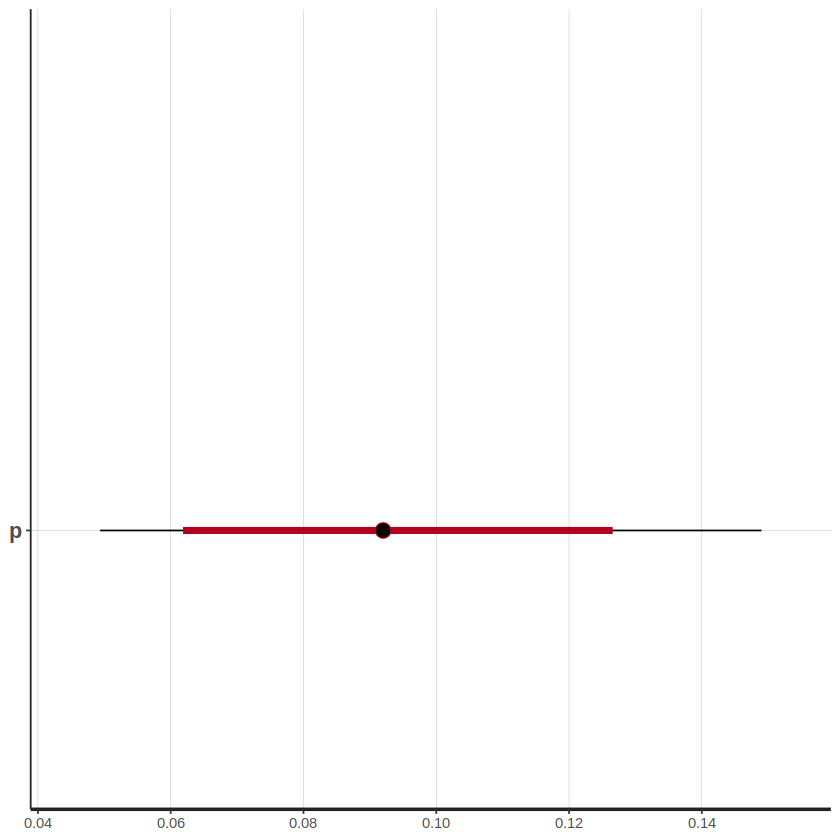

In [ ]:
plot(fit ,pars=c("p"))


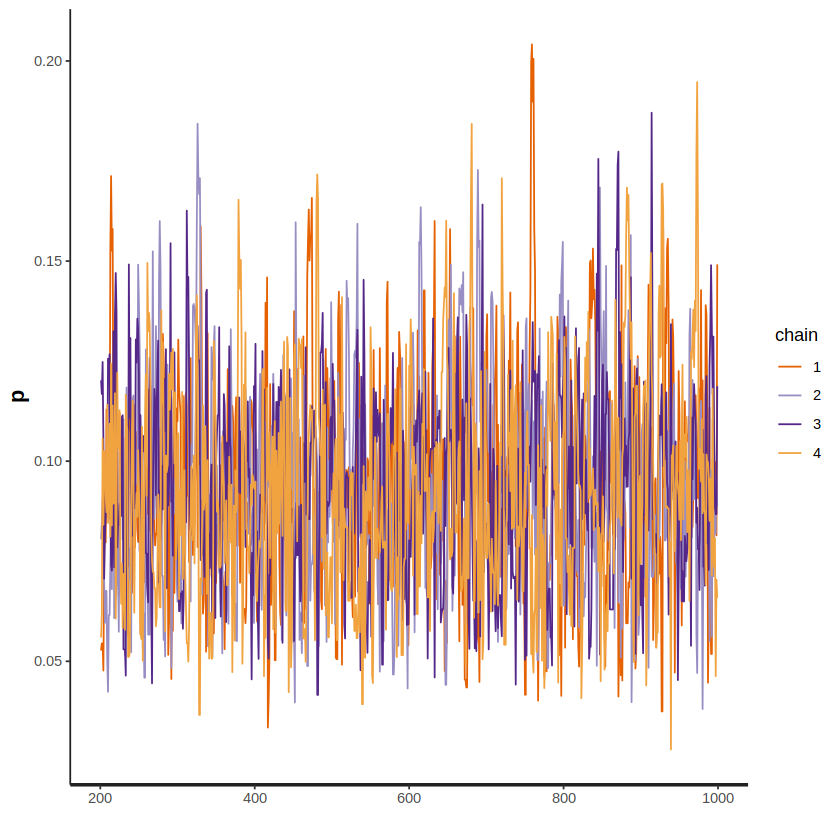

In [ ]:
rstan::traceplot(fit,pars=c("p"))


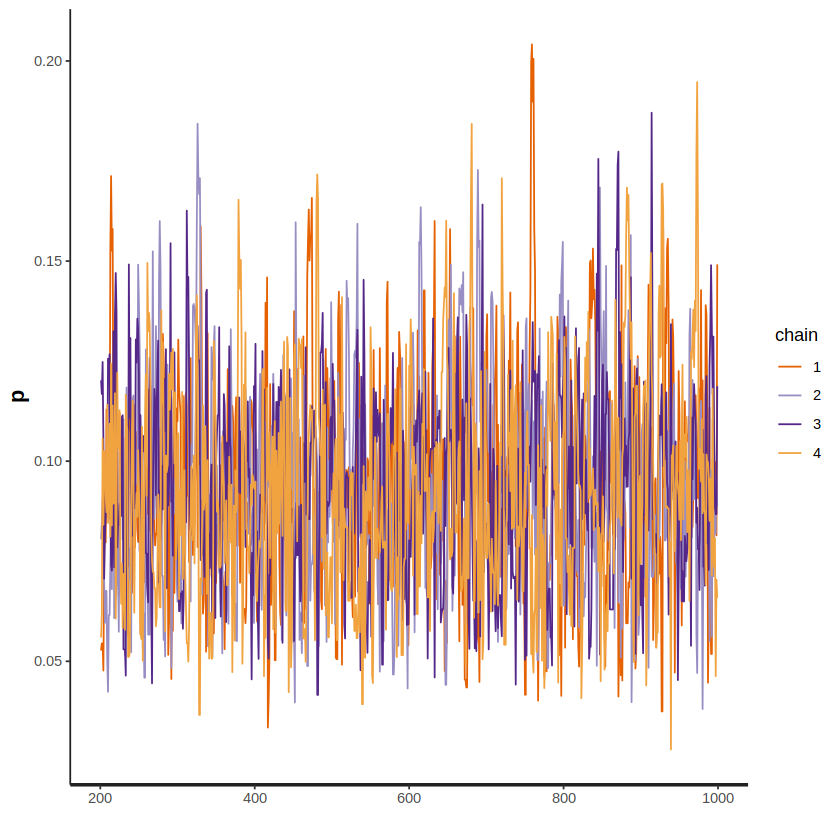

In [ ]:
# alternatively
stan_trace(fit)

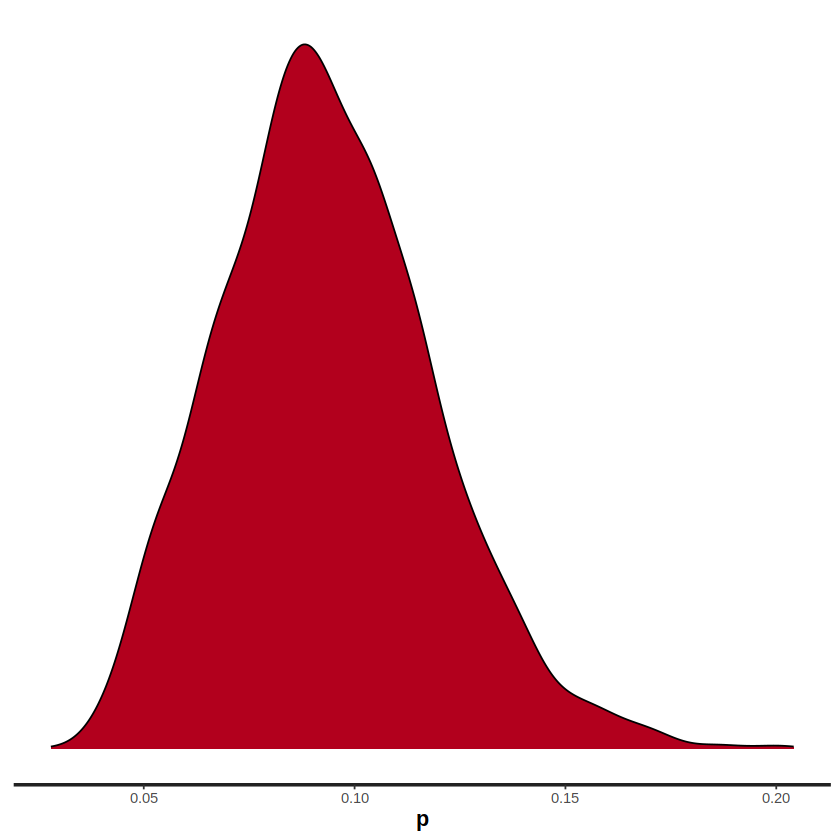

In [ ]:
stan_dens(fit)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


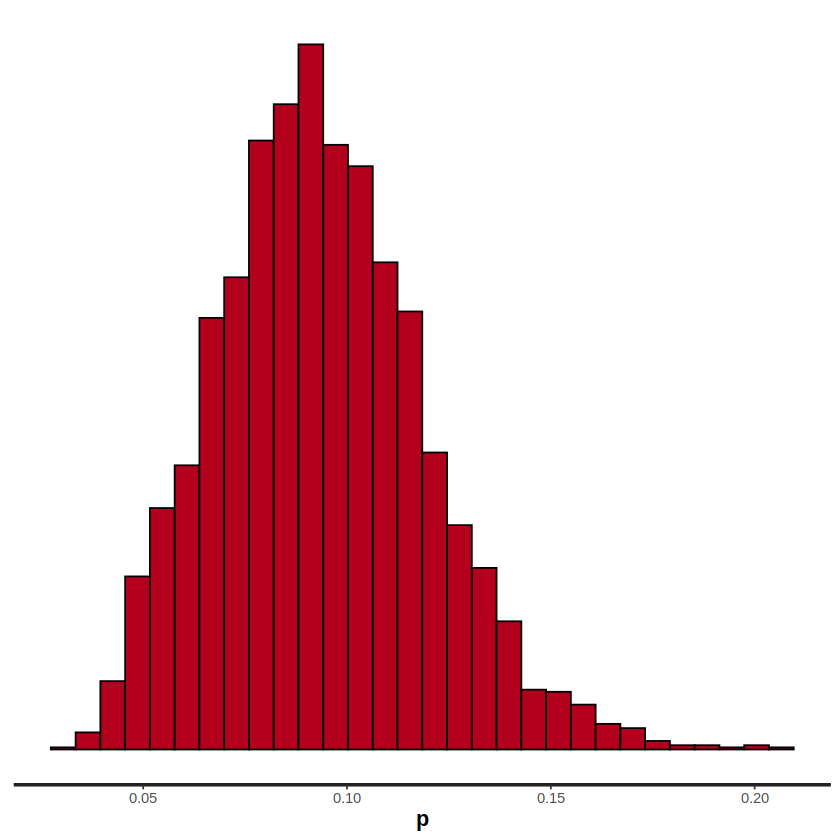

In [ ]:
stan_hist(fit)

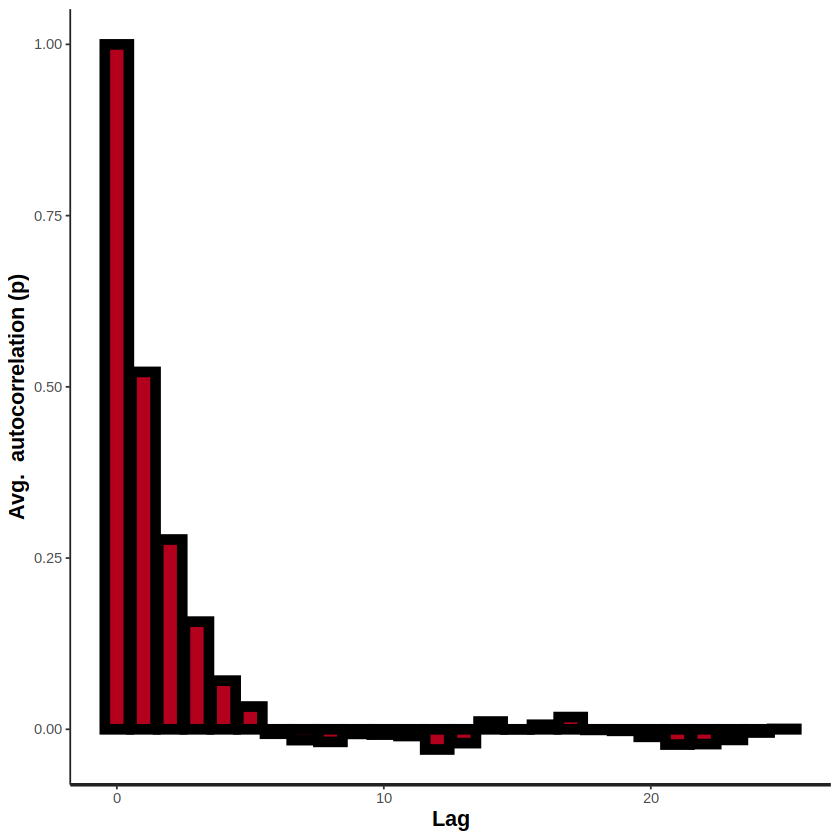

In [ ]:
stan_ac(fit, pars = c("p"))

In [ ]:
# stan_scat(fit,pars=c("p","p")) for correlations graphs